In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable balance (production - consommation) :

* SARIMAX avec des données métier en régresseurs exogènes
* SARIMAX sur le signal sans régresseur
* Régression linéaire sur les données métiers comme variables explicatives

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_W.csv',
                usecols = ['Dates', 'Balance'])
df.head(1)

,Dates,Balance
0,2013-01-06,6459.633333


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

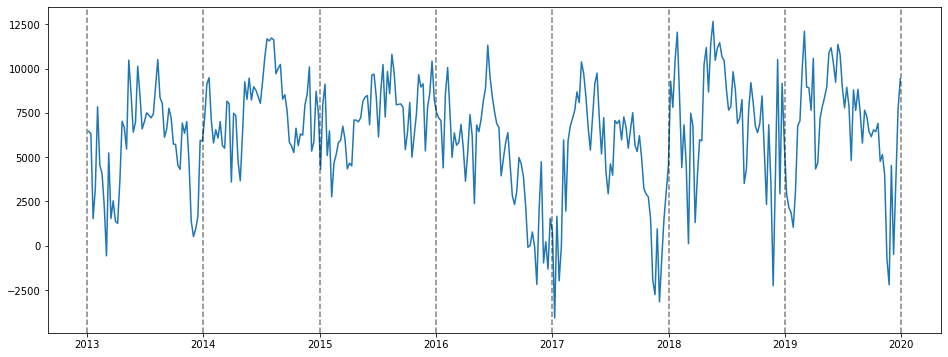

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(df[(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [6]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df)

(-5.840671516107594,
 3.7840356094202356e-07,
 3,
 457,
 {'1%': -3.444740396477859,
  '5%': -2.8678852001919073,
  '10%': -2.570149751878151},
 8033.459894889071)

### Coéfficients SARIMAX et saisonnalités

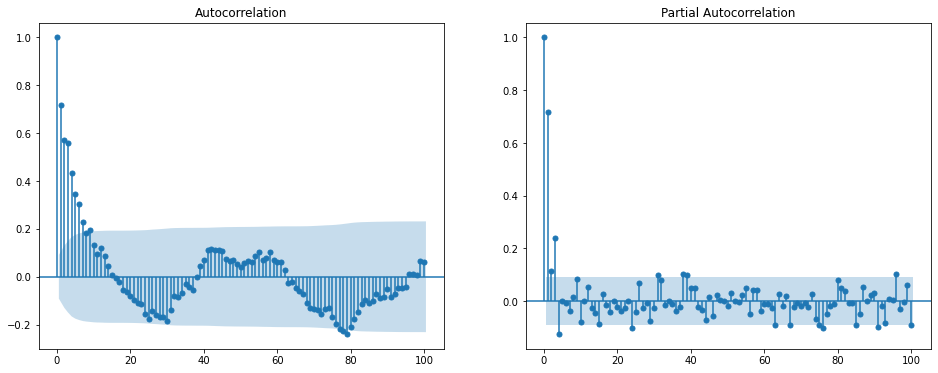

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df, lags = 100, ax=ax1)
plot_pacf(df, lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* Aucune

# Jeux d'entrainement et de test

In [8]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [9]:
fenetre = df_test.shape[0]

In [10]:
indice = df_test.index

In [11]:
bilan = df_test

# Paramètres SARIMAX

In [12]:
ordre = (2,0,4)
saison = (0,0,0,7)

# Régresseurs exogènes : données métier

In [13]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-06,0.861624,0.668611,0.276016,0.047412


In [14]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [15]:
conso = pd.read_csv('./dataset/France_W.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-06,0.861624,0.668611,0.276016,0.047412,61585.265972
2013-01-13,0.916629,1.168683,0.322590,0.045444,69208.047619
2013-01-20,0.921946,1.561792,0.368216,0.037645,78773.818452
2013-01-27,0.915106,1.635786,0.345188,0.056209,76693.806548
2013-02-03,0.885542,0.977115,0.320670,0.070795,67664.690476
...,...,...,...,...,...
2021-10-03,0.631824,0.745542,0.118467,0.133376,45417.133929
2021-10-10,0.654771,1.203024,0.186199,0.149647,47294.294643
2021-10-17,0.707745,1.642417,0.104130,0.165067,50230.895833


In [16]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [17]:
model_exog = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [18]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(2, 0, 4)   Log Likelihood               -3032.728
Date:                Fri, 06 May 2022   AIC                           6089.456
Time:                        08:40:25   BIC                           6136.255
Sample:                             0   HQIC                          6108.054
                                - 365                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5.287e+04   1643.368     32.171      0.000    4.96e+04    5.61e+04
x2          1610.4455    208.460      7.725      0.000    1201.871    2019.020
x3          1.912e+04   1302.058     14.686      0.000    1.66e+04    2.17e+04
x4          3061.7319   1170.638      2.615      0.009     767.324    5356.140
x5            -0.7262      0.027    -27.335      0.000      -0.778      -0.674
ar.L1          0.5448      0.167      3.267      0.001       0.218       0.872
ar.L2          0.4358      0.168      2.593      0.010       0.106       0.765
ma.L1         -0.2690      0.157     -1.712      0.087      -0.577       0.039
ma.L2         -0.3866      0.131     -2.958      0.003      -0.643      -0.130
ma.L3          0.0490      0.063      0.781      0.435      -0.074       0.172
ma.L4         -0.2070      0.063     -3.288      0.001      -0.330      -0.084
sigma2      1.009e+06   8.94e+04     11.284      0.000    8.34e+05    1.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                92.89
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               3.39   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [20]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [21]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Bal_p_exog'])

In [22]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [23]:
bilan['Err_exog'] = np.abs(bilan['Bal_p_exog'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_exog,Err_exog
count,96.000000,96.000000,96.000000
mean,5842.810020,6632.089893,3367.326207
std,3647.341372,2694.449724,2808.643414
min,-2540.845238,-634.028717,41.225935
25%,3314.235863,5134.436853,1115.495439
50%,6500.684524,6618.991100,2401.561713
75%,8696.309524,8496.929139,5558.570510
max,11221.389881,11789.681564,11566.321970


# Sans régresseur

### SARIMAX

In [24]:
model_noreg = sm.tsa.SARIMAX(df_train.values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [25]:
result_noreg = model_noreg.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
result_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(2, 0, 4)   Log Likelihood               -3302.846
Date:                Fri, 06 May 2022   AIC                           6619.692
Time:                        08:40:26   BIC                           6646.991
Sample:                             0   HQIC                          6630.541
                                - 365                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7386   8.26e-06    2.1e+05      0.000       1.739       1.739
ar.L2         -0.7386   8.37e-06  -8.83e+04      0.000      -0.739      -0.739
ma.L1         -1.1179      0.048    -23.074      0.000      -1.213      -1.023
ma.L2          0.0846      0.074      1.140      0.254      -0.061       0.230
ma.L3          0.3097      0.071      4.363      0.000       0.171       0.449
ma.L4         -0.2741      0.050     -5.458      0.000      -0.373      -0.176
sigma2      4.286e+06   4.61e-11    9.3e+16      0.000    4.29e+06    4.29e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.41
Prob(Q):                              0.94   Prob(JB):                         0.30
Heteroskedasticity (H):               1.74   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+35. Standard errors may be unstable.
"""

In [27]:
predict_noreg = result_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [28]:
predict_noreg = pd.DataFrame(predict_noreg, index = indice, columns = ['Bal_p_noreg'])

In [29]:
bilan = pd.concat([bilan, predict_noreg], axis = 1)

### Erreur absolue

In [30]:
bilan['Err_noreg'] = np.abs(bilan['Bal_p_noreg'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_exog,Err_exog,Bal_p_noreg,Err_noreg
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,5842.810020,6632.089893,3367.326207,6343.006925,2999.928987
std,3647.341372,2694.449724,2808.643414,2154.802706,2501.753071
min,-2540.845238,-634.028717,41.225935,822.597586,17.684348
25%,3314.235863,5134.436853,1115.495439,5519.934033,976.826837
50%,6500.684524,6618.991100,2401.561713,6362.394403,2523.501891
75%,8696.309524,8496.929139,5558.570510,7752.463991,4725.783333
max,11221.389881,11789.681564,11566.321970,10849.259918,10745.264977


# Régression linéaire avec Régresseurs exogènes : données métier 

In [31]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-06,0.861624,0.668611,0.276016,0.047412


In [32]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [33]:
conso = pd.read_csv('./dataset/France_W.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-06,0.861624,0.668611,0.276016,0.047412,61585.265972
2013-01-13,0.916629,1.168683,0.322590,0.045444,69208.047619
2013-01-20,0.921946,1.561792,0.368216,0.037645,78773.818452
2013-01-27,0.915106,1.635786,0.345188,0.056209,76693.806548
2013-02-03,0.885542,0.977115,0.320670,0.070795,67664.690476
...,...,...,...,...,...
2021-10-03,0.631824,0.745542,0.118467,0.133376,45417.133929
2021-10-10,0.654771,1.203024,0.186199,0.149647,47294.294643
2021-10-17,0.707745,1.642417,0.104130,0.165067,50230.895833


In [34]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [35]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train)
predict_lr = LinReg.predict(exog_test)

In [36]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Bal_p_LinReg'])

In [37]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [38]:
bilan['Err_LinReg'] = np.abs(bilan['Bal_p_LinReg'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_exog,Err_exog,Bal_p_noreg,Err_noreg,Bal_p_LinReg,Err_LinReg
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,5842.810020,6632.089893,3367.326207,6343.006925,2999.928987,5210.700469,1380.103415
std,3647.341372,2694.449724,2808.643414,2154.802706,2501.753071,2964.195586,1157.418730
min,-2540.845238,-634.028717,41.225935,822.597586,17.684348,-565.504339,22.382185
25%,3314.235863,5134.436853,1115.495439,5519.934033,976.826837,3253.759914,586.997719
50%,6500.684524,6618.991100,2401.561713,6362.394403,2523.501891,5090.111105,1135.467657
75%,8696.309524,8496.929139,5558.570510,7752.463991,4725.783333,7488.824094,1725.394663
max,11221.389881,11789.681564,11566.321970,10849.259918,10745.264977,10704.412118,5813.929723


# Visualisation réel vs prédictions

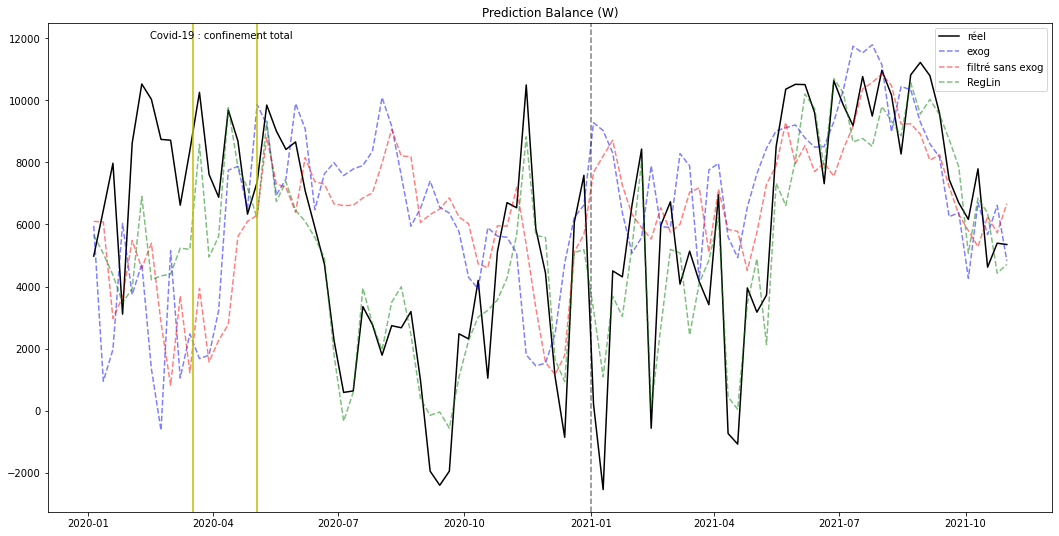

In [42]:
plt.figure(figsize=(18,9))
#plt.plot(df_train.resample('W').mean(), color = 'k')
plt.plot(bilan['Balance'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Bal_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Bal_p_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Bal_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.legend(loc = 'upper right')
plt.title('Prediction Balance (W)')
plt.axvline(dt.datetime(2021, 1, 1), color = 'k', linestyle = '--', alpha = 0.5)
plt.axvline(dt.datetime(2020, 3, 17), color = 'y')
plt.axvline(dt.datetime(2020, 5, 3), color = 'y')
plt.text(dt.datetime(2020, 2, 15), 12000, 'Covid-19 : confinement total')
plt.savefig('./results/W/pred_balance_W.png');

# Synthèse des erreurs

In [40]:
erreur = bilan[['Err_exog',
       'Err_noreg',
       'Err_LinReg'
      ]].describe()
erreur

,Err_exog,Err_noreg,Err_LinReg
count,96.000000,96.000000,96.000000
mean,3367.326207,2999.928987,1380.103415
std,2808.643414,2501.753071,1157.418730
min,41.225935,17.684348,22.382185
25%,1115.495439,976.826837,586.997719
50%,2401.561713,2523.501891,1135.467657
75%,5558.570510,4725.783333,1725.394663
max,11566.321970,10745.264977,5813.929723


In [41]:
bilan.to_csv('./results/W/bilan_balance_W.csv', sep = ';')
erreur.to_csv('./results/W/erreur_balance_W.csv', sep = ';')